## Скрипт формирования Сабмита


In [ ]:
import requests
from pathlib import Path
from tqdm import tqdm
import os
import pandas as pd

df = pd.DataFrame(columns=['image', 'recs'])
url = 'https://api.meiiiok.ru/api/search' #ссылка на поисковый сервис
test = './test_data_rkn/dataset/'
csv_name = 'submit2'

for file in tqdm(os.listdir(test)):
    with open(Path(test) / file, 'rb') as image_file:
        f = {'image': image_file}

        response = requests.post(url, files=f)

    resp = response

    predict = []
    first_pred = []
    try:
        for i in resp.json()[:10]:
            predict.append(i['name'])
        predict_str = ','.join(map(str, predict))


    except:
        print(file)
        print(len(resp.json()))

    new_row = pd.DataFrame({'image': file, 'recs': [predict_str]})
    df = pd.concat([df, new_row], ignore_index=True)

df.to_csv(f'{csv_name}.csv', index=False)
    

## Скрипт вырезания картинки из скриншота



In [19]:
import cv2
import numpy as np
from pathlib import Path
from PIL import Image

pth = "./screenshot_3.png"
with open(pth, 'rb') as image_file: # функция преобразования в байты для встраивания в сервис
    image_bytes = image_file.read()

def cut_box(byte_img: bytes) -> bytes:
    nparr = np.frombuffer(byte_img, np.uint8)
    img_np = cv2.imdecode(nparr, cv2.IMREAD_COLOR) 

    img_to_rgb = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB) # Переводим в РГБ

    blurred = cv2.GaussianBlur(img_to_rgb, (5, 5), 0) # Блюрим границу

    _, thresh = cv2.threshold(blurred, 70, 255, cv2.THRESH_BINARY) # определяем границу маски
    thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY) # переводим изобржение в серый


    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    largest_contour = max(contours, key=cv2.contourArea) # Находим самый большой прямоугольник

    x, y, w, h = cv2.boundingRect(largest_contour)
     
    if w<img_np.shape[0]/10 or h<img_np.shape[1]/10: # Если прямоугольник маленький - не обрезаем изображение 

        return img_np.tobytes()
  
    cropped_image = img_np[y:y+h, x:x+w]
    #print(type(cropped_image))

    return encode_bytes(cropped_image, extension='.png')

def encode_bytes(img: np.array, extension:  str):  # 
    _, im_buf_arr = cv2.imencode(extension, img)
    byte_im = im_buf_arr.tobytes()
    return byte_im

b_img = cut_box(image_bytes)


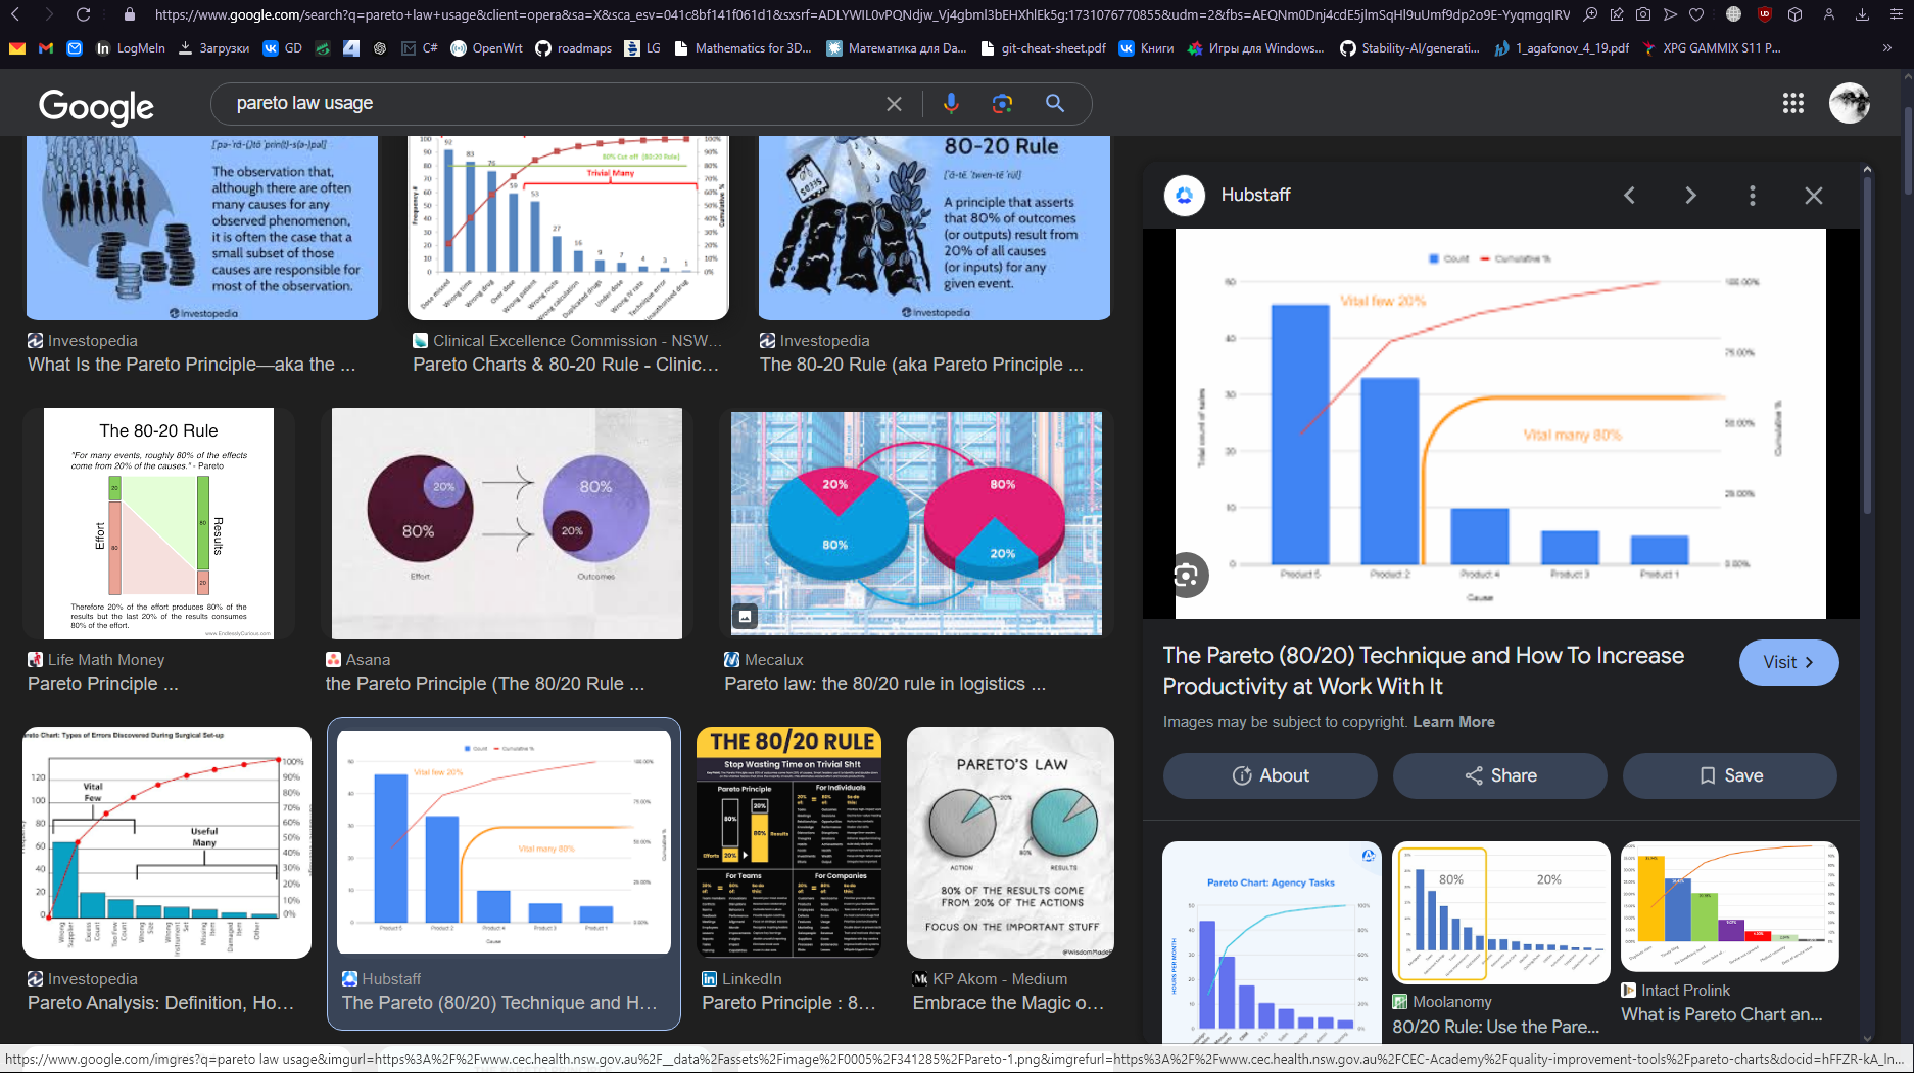

In [20]:
Image.open(pth) # исходное изображение

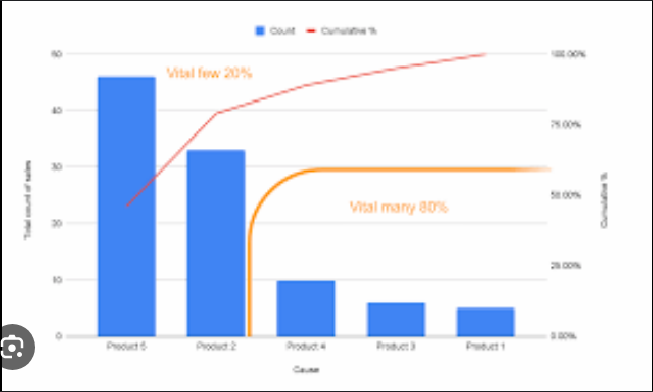

In [21]:
im = np.frombuffer(b_img, np.uint8)
img_np = cv2.imdecode(im, cv2.IMREAD_COLOR)
swapped_image = img_np[:, :, [2, 1, 0]]
Image.fromarray(swapped_image)

## Скрипт расчёта MAP@10

In [24]:
def average_precision_at_k(true_label, pred_labels, k=10):
    pred_labels = pred_labels[:k]
    
    relevant_count = 0
    precision_at_k = []
    
    if k>len(pred_labels):
        k = len(pred_labels)

    for i, label in enumerate(pred_labels):

        if label == true_label:
            
            relevant_count += 1
            precision = relevant_count / (i + 1) 
            precision_at_k.append(precision)

    if relevant_count == 0:
        return 0  
    return sum(precision_at_k) / k


def mean_average_precision_at_k(all_true_labels, all_pred_labels, k=10):

    average_precisions = [
        average_precision_at_k(true_label, pred_labels, k)
        for true_label, pred_labels in zip(all_true_labels, all_pred_labels)
    ]
    return sum(average_precisions) / len(average_precisions) if average_precisions else 0

In [26]:
k=10

all_true_classes = "Willow"             


all_pred_classes = ["Willow", "Willow", "Willow"]
ap_10 = average_precision_at_k(all_true_classes, all_pred_classes, k=k)



print("AP@10:", ap_10)

AP@10: 1.0
